In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# VibNet 

### End-to-end neural network for time series classification and frequency domain feature extraction

#### Michael Poli, KAIST

Sequential data, along with image data and more recently geometric data (e.g graphs) has always been at the core of artificial intelligence. The standard deep learning architectures, recurrent neural networks (RNNs) and convolutional neural networks (CNNs), among others, are all able to solve many kinds of supervised learning problems without need for particular modifications. However, there is a fundamental structural difference between sequential and image data: the former often includes time dependencies between its components. This fact has inspired the deep learning community to revise the standard RNNs architecture as to include a pseudo-memory mechanism. Due to this feature, the resulting long short term memory networks (LSTM) have for the longest time been believed to be the most appropriate for handling sequential data learning problems.
This belief has recently been challenged, and it has been shown [1] that temporal convolutional networks can often outperform recurrent neural networks in sequential data modeling. This is due to the fact that memory gates in LSTMs are often not able to capture extremely long time dependencies, which can often occur while working with strings of thousands of tokens in natural language processing.

While in deep learning computer vision and natural language processing (NLP) seem to be at the forefront of innovation, more and more effort is being expended in adapting architectures and techniques to new areas, often combining reinforcement learning ideas to handle semi-supervised or unsupervised learning scenarios. One such area is that of signal processing. The theory behind signal processing is very well developed: in terms of supervised learning problems it has been particularly challenging for deep learning to go up against decades of refined, application specific hand-crafted features and statistics that often give very good results. Nonetheless, given the fact that many new deep learning techniques are being developed and adapted to this domain, namely attention modules [2] and dilated convolutions [3], deep learning is starting to outperform classic machine learning techniques.

The following notebook is a demonstration of our novel temporal convolutional neural network, VibNet, designed to solve supervised classification problems from raw time domain data.
We tested our architecture against the Case Western Reserve University [4] dataset for mechanical bearing fault classification.
The main advantage of our solution over other state-of-the-art techniques involving convolutions is that it takes as input only raw time domain data, thus making it very appealing for time sensitive, online fault monitoring or classification applications. Furthermore, we exploit pre-existing characteristics of time series to achieve improved interpretability. We do so by applying a strong inductive bias in the first few layers via dilated convolutions. Additionally, we add multiple parallel convolutional paths as to achieve a so called "multi-head" architecture, where each path has a different dilation coefficient. 

The intuition behind dilation is that it is a form of downsampling of the signal. Different dilation coefficients cause downsampling of different magnitudes. By forcing the network to use features of signals downsampled to different frequencies we can learn more about which frequency bands the network chooses to focus on while at the same time teaching it about the nature of its input data. 

### Motivation

The main goals of this new architecture are rivaling state of the art approaces in terms of classification accuracy in a complete end to end learning scenario, while also trying to obtain improved interpretability.

### Advantages over other SoTA approaches

#### End to end, raw time series

Other state of the art approaches for fault condition monitoring suffer from one key issue. While deep learning approaches in general stick to a more minimalistic form of data preprocessing, straying away from performing wavelet analysis or creating theoretically sound, complex signal processing features manually or in a pipeline from the raw data in the time domain, they still rely on frequency information being part of the input to the network. This is often done via FFTs (fast fourier transform)
of the time series data, that are then added to the raw data as additional input channels. In embedded, online, time critical applications this far from the optimal solution. We can leverage the strong expressivity of CNNs to solve the problem in a complete end-to-end fashion, directly from time domain to fault type. This feature of VibNets makes them particularly easy to implement in embedded systems, particularly so via weight quantization or other network compression techniques.

#### Interpretability

Since deep learning based systems have become prevalent in many industries and are sometimes at the core of sensitive decision making strategies, many researchers and practicioners are realizing the importance of peeking in and understanding what really goes on inside the magic black box. Other very recent works [5] have tried to tackle interpretability in signal processing by placing strong biases in the first convolutional layers. The argument goes as follows: even if the network starts with only time domain data, by architectural choices we can 'teach' it about the frequency domain and the periodic nature of the input data. As a side effect, a stronger bias also helps combat overfitting, problem which can often occur in applications with small training datasets.

It is particularly appealing to draw parallels between this type of problem and the issue of image segmentation in computer vision. Historically, there have been many different approaches for finding meaningful segmentation of image data, starting with multi-stage approaches (RCNN) in 2015. Nowadays one stage techniques are more popular due to their versatility and the fact that they can be used in online applications. The goal is then that of embedding the segmentation process inside the architecture. In signal processing the goal to strive for is still obtaining interpretable, orthogonal components, with the caveat that this time they are not in pixel space but in frequency domain, which can be viewed as a latent space of the input time series. This adds complexity to this issue.

# Code and Experiments

Requirements: 
python v3.6
fastai v0.7 
torch 
scipy

In [18]:
import torch 
from fastai.conv_learner import *
import torch.nn as nn
import scipy
import utils
#personal module that preprocesses the CWRU data
import CRWU_preprocess as P

### Explicit utilities 

We used the following utility functions:

In [20]:
def get_power(time_series, ch):
    '''
    Computes the power spectral density of a 1D time series at a specific channel
    Inputs:
    time_series = 1D time series of size (batch_size, channel, -1). type: torch.Tensor.cuda()
    ch = channel of which to compute the power spectral density
    Ouputs: power spectral density, type: numpy array
    '''
    re = torch.rfft(time_series, 1).detach().cpu().numpy()[0,ch,:,0]
    im = torch.rfft(time_series, 1).detach().cpu().numpy()[0,ch,:,1]
    return np.sqrt(re**2+im**2)

def fourier_split(psd, size):
    '''
    Split a frequency signal into three chunks of size = size
    3*size has to be less or equal than original size
    '''
    return psd[0:size],psd[size:2*size],psd[2*size:3*size]

def pred_accuracy(m, valloader, val_size):
    '''
    Calculates accuracy from a given model and validation DataLoader
    Device assumed to be cuda
    '''
    m.eval()
    count = 0
    y_hat = np.zeros(int(val_size))
    for i, data in enumerate(valloader):
        x_val, y_val = data
        pr = m(x_val.view(1,-1))
        val, indx = torch.max(pr.cuda(),1)
        if y_val - indx == 0:
            count += 1
    return count/int(val_size)

class Attention(nn.Module):
    '''
    Scaled dot product attention
    '''
    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention = new_parameter(attention_size, 1)
    
    def get_param(self):
        return self.attention

    def forward(self, x_in):
        # after this, we have (batch, dim1) with a diff weight per each cell
        attention_score = torch.matmul(x_in, self.attention).squeeze()
        attention_score = F.softmax(attention_score).view(x_in.size(0),-1)
        scored_x = torch.sum(x_in * attention_score, dim=1)

        # now, sum across dim 1 to get the expected feature vector
        #condensed_x = torch.sum(scored_x, dim=1)
        return scored_x

def new_parameter(*size):
    out = nn.Parameter(torch.FloatTensor(*size).cuda())
    nn.init.xavier_normal_(out)
    return out

def tensor_from_dataloader(loader):
    x = {}
    y = {}
    for i, data in enumerate(valloader):
        x[i], y[i] = data
    return x, y

Case Western Reserve University dataset loading:
For this demonstration, we used a training set of 2080 time series and validation set of 892 time series.

In [28]:
# insert PATH of your CWRU dataset here
PATH = 'L:/vibnet-hankooktire/CWRUdata'
(trainloader, valloader) = P.CWRUdata()

# obtain readily accessible tensors for test data, from the dataloader
x_tr, y_tr = tensor_from_dataloader(valloader)
x_val, y_val = tensor_from_dataloader(trainloader)

## VibNet model

The architecture can be thought of being a combination of 2 functional components. The first, is designed to make feature extraction and abstraction easier for the network by performing convolutions at different dilation levels. For more details on dilated convolutional filters, refer to [3]. The second component is a standard stack of convolutional blocks, with ReLU activations, batch-norm and pooling, designed to take as input the concatenated result of the multi-head component, weighted by an attention module, and perform additional abstraction in order to produce a classification output.

In [51]:
class VibNet(nn.Module):
    '''
    Multi-head TCN for raw single channel sequential data
    Takes lists of layers to initialize an instance. path 1, path 2, path 3, shared convolutional layers, dense layers.
    e.g m = VibNet([1, 3, 1], [1, 3, 1], [1, 3, 1], [3,3,12,64,256], [256, 4])
    Attention size for the concatenated convolutional paths is hard coded and has to be determined for different choices 
    of dilation
    '''
    def __init__(self, conv_layers1, conv_layers2, conv_layers3, conv_post, layers):
        super().__init__()
        # path 1
        self.conv_layers1 = nn.ModuleList([nn.Conv1d(conv_layers1[i], conv_layers1[i + 1], kernel_size = 10, dilation=1) 
                                     for i in range(len(conv_layers1) - 1)])
        # path 2
        self.conv_layers2 = nn.ModuleList([nn.Conv1d(conv_layers2[i], conv_layers2[i + 1], kernel_size = 10, dilation=10) 
                                     for i in range(len(conv_layers2) - 1)])
        # path 3
        self.conv_layers3 = nn.ModuleList([nn.Conv1d(conv_layers3[i], conv_layers3[i + 1], kernel_size = 10, dilation=20) 
                                     for i in range(len(conv_layers3) - 1)])
        # shared convolutions
        self.conv_post = nn.ModuleList([nn.Conv1d(conv_post[i], conv_post[i + 1], kernel_size = 15, dilation=1) 
                                     for i in range(len(conv_post) - 1)])
        # dense layer
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
        # gaussian noise for data augmentation at runtime
        self.noise = utils.GaussianNoise(0.05)
        
        # several other useful modules that might or might not be used
        self.max = nn.MaxPool1d(4) 
        self.dropout = nn.Dropout(p=0.33)
        self.gp = nn.AdaptiveMaxPool1d(1)
        self.mp = nn.AdaptiveMaxPool1d(2000)
        # hardcoded attention size. has to be determined for each combination of dilations, depth of conv paths etc.
        # needs to be a multiple of 3. Optional
        self.attention = Attention(5586)
    
    def get_weights(self, layer):
        '''
        Obtain the weights of path 1, path 2, path 3 layers.
        input: layer number. returns (w1, w2, w3), the weights of each path at the specified layer
        '''
        weights1 = self.conv_layers1[layer].weight.data.cpu().numpy()
        weights2 = self.conv_layers2[layer].weight.data.cpu().numpy()
        weights3 = self.conv_layers3[layer].weight.data.cpu().numpy()
        
        return weights1, weights2, weights3
    
    def plot_latent_components(self, val, psd_flag = None):
        '''
        Takes as input a single validation time series
        Plots the latent time series activations (or power spectral density if psd_flag = True)
        for each of the path's final layer
        '''
        val = val.view(1,1,-1)
        if psd_flag:
            p1, p2, p3 = m.evaluate_paths(val)
            fig = plt.figure(figsize=(20,20), facecolor = 'white')
            fig.add_subplot(4,1,1) 
            plt.plot(get_power(val,0)[10::], color = 'black')
            fig.add_subplot(4,1,2)
            plt.plot(get_power(p1.view(1,1,-1),0)[10::], color = 'red')
            fig.add_subplot(4,1,3)
            plt.plot(get_power(p2.view(1,1,-1),0)[10::], color = 'green')
            fig.add_subplot(4,1,4)
            plt.plot(get_power(p3.view(1,1,-1),0)[10::], color = 'blue')    
        else:
            p1, p2, p3 = self.evaluate_paths(val)
            fig = plt.figure(figsize=(20,20), facecolor = 'white')
            fig.add_subplot(4,1,1) 
            plt.plot(val.view(-1).detach().cpu().numpy(), color = 'black')      
            fig.add_subplot(4,1,2)
            plt.plot(p1.view(-1).detach().cpu().numpy(), color = 'red')
            fig.add_subplot(4,1,3)
            plt.plot(p2.view(-1).detach().cpu().numpy(), color = 'green')
            fig.add_subplot(4,1,4)
            plt.plot(p3.view(-1).detach().cpu().numpy(), color = 'blue')
        
    def evaluate_paths(self, x):
        '''
        Used to obtain latent time series at inference time
        Uses the learned weights and the same architecture to manipulate validation data
        '''
        x = x.view(x.size(0), 1, -1)
        if m.training:
            x = self.noise(x)
        #save input
        s = x      
        for l in self.conv_layers1:
            l_x = l(x)
            x = torch.tanh(l_x) 
            #x = self.max(x)
        #x = self.conv_dil1(x)
        x1 = x
        x = s
        for l in self.conv_layers2:
            l_x = l(x)
            x = torch.tanh(l_x)
            #x = self.max(x)
        #x = self.conv_dil3(x)
        x2 = x
        x = s
        for l in self.conv_layers3:
            l_x = l(x)
            x = torch.tanh(l_x)
            #x = self.max(x)
        #x = self.conv_dil5(x)
        x3 = x
        return x1, x2, x3
       
    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        if m.training:
            x = self.noise(x)
        #save input
        s = x
        for l in self.conv_layers1:
            l_x = l(x)
            x = torch.tanh(l_x)
            #x = self.max(x)
        #x = self.conv_dil1(x)
        x1 = x
        x = s
        for l in self.conv_layers2:
            l_x = l(x)
            x = torch.tanh(l_x)
            #x = self.max(x)
        #x = self.conv_dil3(x)
        x2 = x
        
        x = s
        for l in self.conv_layers3:
            l_x = l(x)
            x = torch.tanh(l_x)
            #x = self.max(x)
        #x = self.conv_dil5(x)
        x3 = x
        
        x = torch.cat((x1, x2, x3), 2)
        x = self.attention(x)
        x = x.view(s.size(0), 3, -1)
        
        for l in self.conv_post:
            l_x = l(x)
            bn = nn.BatchNorm1d(x.size())
            x = F.relu(l_x)
            #x = self.max(x)
        x = self.gp(x)
        
        x = x.view(x.size(0), -1)   
        for l in self.layers:
            l_x = l(x)
            bn = nn.BatchNorm1d(l_x.size())
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [55]:
m = VibNet([1, 30, 1], [1, 30, 1], [1, 30, 1], [3,3,12,64,256], [256, 4]).cuda()
loss = nn.NLLLoss()
md = ModelData(PATH, trainloader, valloader)
learn = Learner(md, m)
# training
m.train()
opt = optim.Adam(m.parameters(), weight_decay=0, lr=0.001)
fit(m, md, 1, opt, crit=loss)
opt = optim.Adam(m.parameters(), weight_decay=0, lr=0.0005)
fit(m, md, 2, opt, crit=loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.207653   0.098816  



epoch      trn_loss   val_loss                                                                                         
    0      0.031673   0.018277  
    1      0.012925   0.012038                                                                                         



[0.012038043979241792]

Accuracy: 99.6%

In [56]:
pred_accuracy(m, valloader, 892)

0.9966367713004485

### Experiment setup

In [38]:
e = {}

for i in range(10):
    m = VibNet([1, 20, 1], [1, 20, 1], [1, 20, 1], [3,3,12,64,256], [256, 4]).cuda()
    loss = nn.NLLLoss()
    md = ModelData(PATH, trainloader, valloader)
    learn = Learner(md, m)
    # training
    m.train()
    opt = optim.Adam(m.parameters(), weight_decay=0, lr=0.001)
    fit(m, md, 1, opt, crit=loss)
    opt = optim.Adam(m.parameters(), weight_decay=0, lr=0.0005)
    fit(m, md, 3, opt, crit=loss)
    e[i] = pred_accuracy(m, valloader, 892)

epoch      trn_loss   val_loss                                                                                         
    0      0.122099   0.065941  



epoch      trn_loss   val_loss                                                                                         
    0      0.102111   0.023491  
    1      0.029826   0.018702                                                                                         
    2      0.008953   0.004187                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.453683   0.310907  



epoch      trn_loss   val_loss                                                                                         
    0      0.098408   0.079157  
    1      0.032435   0.024945                                                                                         
    2      0.240309   0.021887                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.076674   0.061308  



epoch      trn_loss   val_loss                                                                                         
    0      0.042344   0.019608  
    1      0.016786   0.025568                                                                                         
    2      0.059701   0.190711                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.615934   0.581036  



epoch      trn_loss   val_loss                                                                                         
    0      0.065268   0.093279  
    1      0.01996    0.045731                                                                                         
    2      0.103653   0.091638                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.086159   0.056131  



epoch      trn_loss   val_loss                                                                                         
    0      0.014261   0.020441  
    1      0.152691   0.028589                                                                                         
    2      0.057185   0.022619                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.150437   0.105952  



epoch      trn_loss   val_loss                                                                                         
    0      0.149698   0.021438  
    1      0.008354   0.00719                                                                                          
    2      0.005241   0.011136                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.238308   0.382062  



epoch      trn_loss   val_loss                                                                                         
    0      0.066399   0.050224  
    1      0.086373   0.016709                                                                                         
    2      0.007565   0.013238                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.209503   0.236698  



epoch      trn_loss   val_loss                                                                                         
    0      0.050033   0.056349  
    1      0.018595   0.013428                                                                                         
    2      0.023844   0.021381                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.063609   0.044985  



epoch      trn_loss   val_loss                                                                                         
    0      0.134138   0.037705  
    1      0.008132   0.01199                                                                                          
    2      0.004583   0.008022                                                                                         



epoch      trn_loss   val_loss                                                                                         
    0      0.107412   0.033049  



epoch      trn_loss   val_loss                                                                                         
    0      0.235616   0.039487  
    1      0.011784   0.006504                                                                                         
    2      0.002832   0.007196                                                                                         



While achieving the best possible accuracy was not the main goal of this architecture, we still obtain very competitive results compared to other techniques, which make use of bigger training datasets and perform preprocessing on the time domain data. [6][7] for more information on other SoTA results.
Additionally, due to the more resilient nature of VibNets with respect to overfitting, performance can be improved very simply by tuning hyperparameters or adding additional convolutional layers. 

In [44]:
sum = 0
count = 0
for acc in e.values():
    sum += acc
    count += 1
print('Accuracy over 10 runs: ' + str(sum/count))

Accuracy over 10 runs: 0.9862107623318384


## Example plots of intermediate activations

The following are plots of intermediate activations, specifically taken from the last layer of the multi-head component of a VibNet. The three colors red, green, blue represent the three different heads of the multi-head section, whereas the black time series is taken straight from the validation dataset as comparison.
The following visualizations can be used to observe which frequency bands each of the three heads of the VibNet focuses on.

#### (Time domain):  validation time series (black) vs activations (red, green, blue)

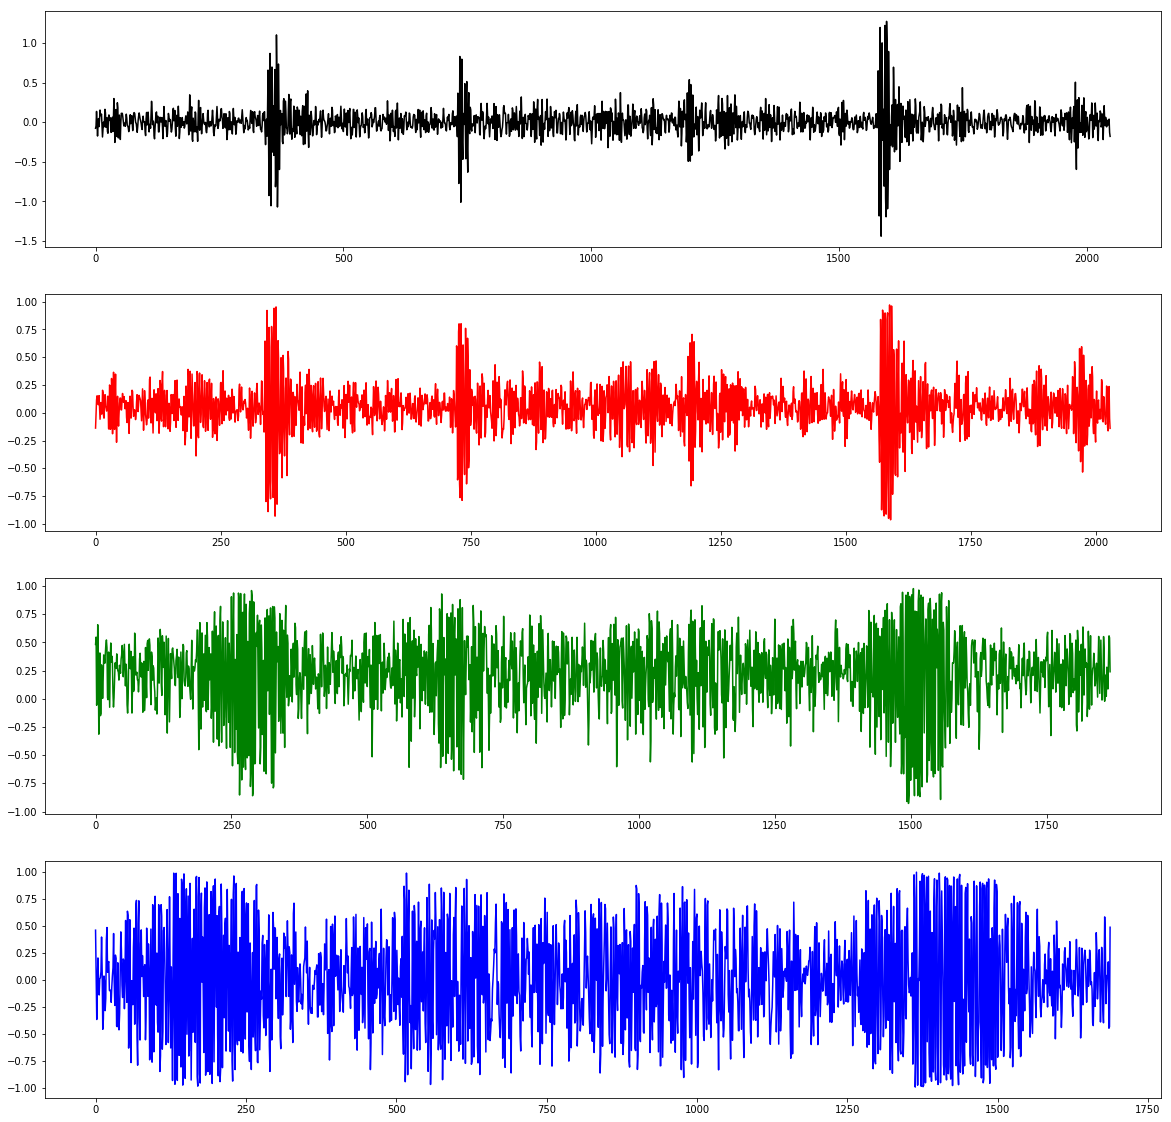

In [63]:
m.plot_latent_components(x_val[420])

#### (Frequency domain): validation time series (black) vs activations (red, green, blue)

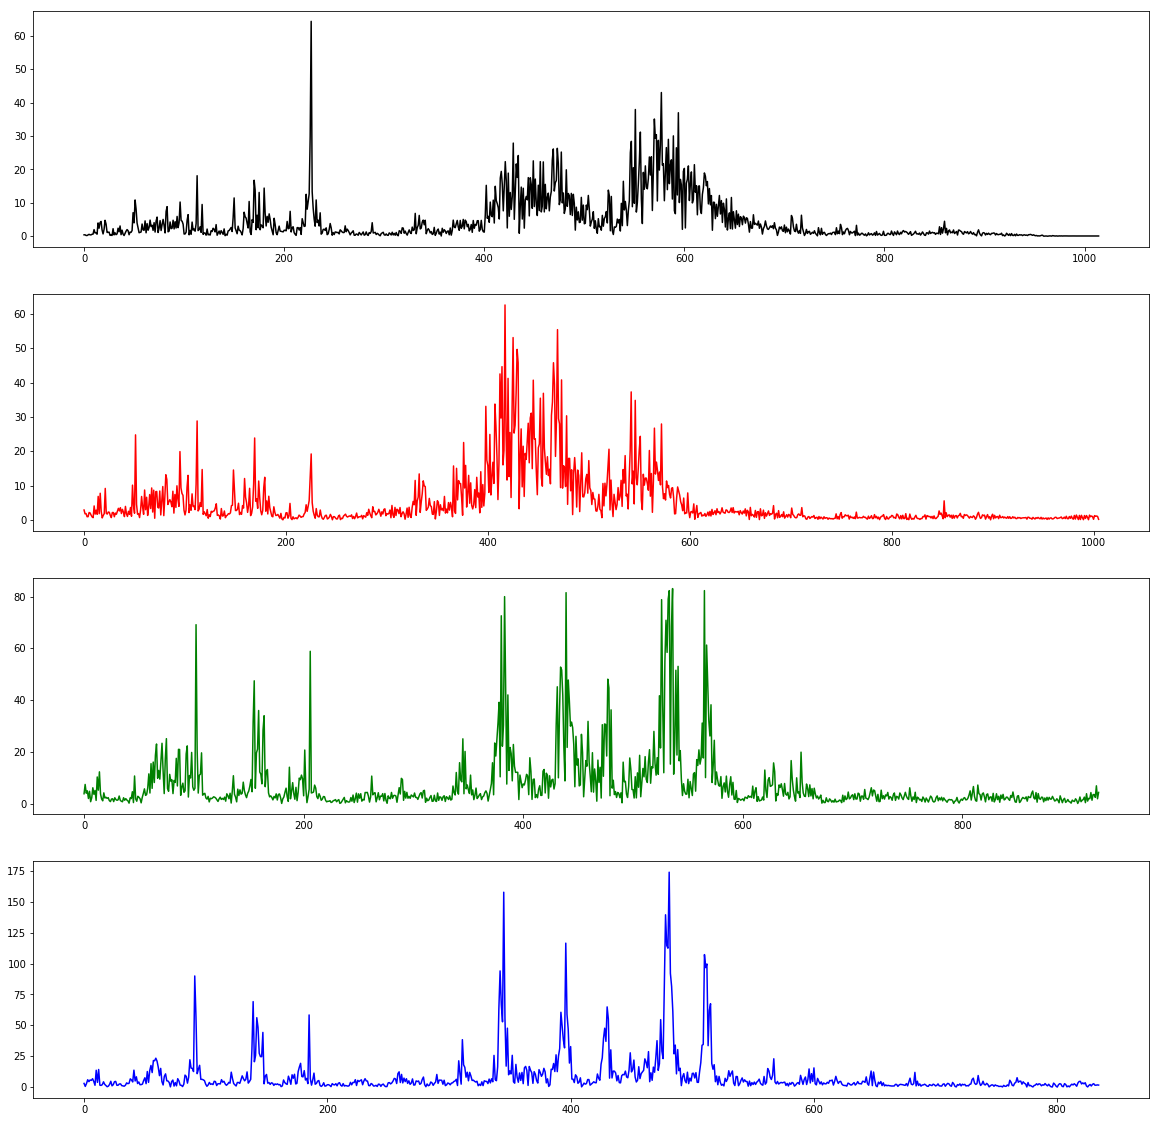

In [62]:
m.plot_latent_components(x_val[420], True)

#### References

-[1] Bai, S., Kolter, J. Z., & Koltun, V. (2018). An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. Retrieved from http://arxiv.org/abs/1803.01271

-[2] Vaswani, A., Smhazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention Is All You Need, (Nips). https://doi.org/10.1017/S0140525X16001837


-[3] Oord, A. van den, Dieleman, S., Zen, H., Simonyan, K., Vinyals, O., Graves, A., … Kavukcuoglu, K. (2016). WaveNet: A Generative Model for Raw Audio, 1–15. https://doi.org/10.1109/ICASSP.2009.4960364

-[4] CWRU data: https://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website

-[5] Ravanelli, M., & Bengio, Y. (2018). Speaker Recognition from Raw Waveform with SincNet. Retrieved from http://arxiv.org/abs/1808.00158

-[6] Yao, Y., Wang, H., Li, S., Liu, Z., Gui, G., Dan, Y., & Hu, J. (2018). End-To-End Convolutional Neural Network Model for Gear Fault Diagnosis Based on Sound Signals. Applied Sciences, 8(9), 1584. https://doi.org/10.3390/app8091584

-[7] Zhang, W., Peng, G., Li, C., Chen, Y., & Zhang, Z. (2017). A new deep learning model for fault diagnosis with good anti-noise and domain adaptation ability on raw vibration signals. Sensors (Switzerland), 17(2). https://doi.org/10.3390/s17020425